# Problem 1

In [20]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

HW2 의 코드가 제대로 동작하지 않는 관계로 yfinance의 상위 주식들을 첨부합니다. 

In [21]:
# 데이터 수집
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'TSLA', 'META' , 'LLY', 'V', 'JPM', 'XOM', 'TSM', 'UNH', 'WMT', 'JNJ', 'PG', 'HD', 'CVX', 'ORCL', 'BAC', 'MRK', 'ABBV', 'KO', 'PEP', 'ADBE', 'CSCO', 'BABA', 'CRM', 'MCD', 'TMO', 'PFE','DHR','CMCSA','ABT','NFLX','TMUS','AMD','INTC','WFC','DIS','MS','PM']  # 이 부분에 원하는 주식의 ticker를 넣습니다.
start_date = '2020-01-01'
end_date = '2023-01-01'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  42 of 42 completed


In [22]:
# 데이터 처리
returns = data.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()


In [23]:
# 효율적 경계 및 자본시장선 계산
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
risk_free_rate = 0.01

In [24]:
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stddev  # Sharpe Ratio

return_range = np.linspace(min(results[0]), max(results[0]), 100)
capital_market_line = risk_free_rate + ((mean_returns - risk_free_rate).max() / results[1, results[0].argmax()]) * (return_range - risk_free_rate)


In [25]:
# CML 계산
return_range = np.linspace(0, max(results[0]) + 0.02, 100)
max_sharpe_idx = np.argmax(results[2])
slope = (results[0, max_sharpe_idx] - risk_free_rate) / results[1, max_sharpe_idx]
cml = risk_free_rate + slope * (return_range - risk_free_rate)

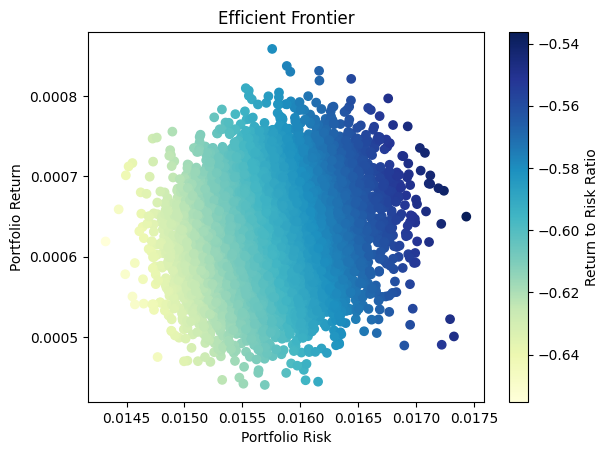

In [26]:
# 그래프 그리기
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Return to Risk Ratio')
plt.show()

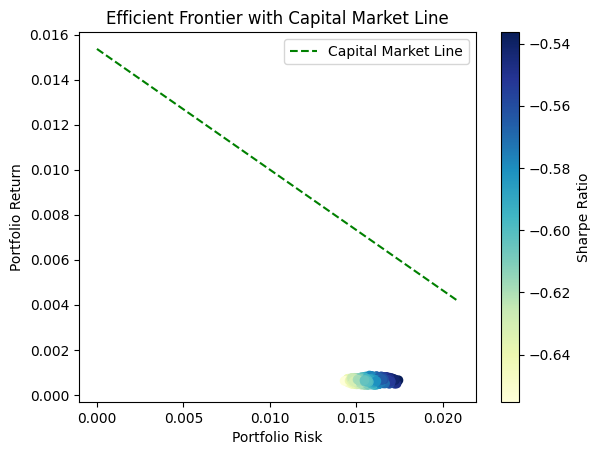

In [27]:
# 그래프 그리기
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.plot(return_range, cml, color='green', linestyle='--', label='Capital Market Line')
plt.title('Efficient Frontier with Capital Market Line')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.show()

In [29]:
data = yf.download(tickers + ['^GSPC'], start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  43 of 43 completed


In [30]:
# 일일 수익률 계산
returns = data.pct_change().dropna()
market_returns = returns['^GSPC']
risk_free_rate = 0.01  # 1%를 가정

In [33]:
alphas_dict = {}

for ticker in tickers:
    
    beta, alpha_intercept = np.polyfit(market_returns.values, returns[ticker].values, 1)
    
    
    expected_return = risk_free_rate + beta * (market_returns.mean() * 252 - risk_free_rate)
    
    # Alpha 계산
    alpha = returns[ticker].mean() * 252 - expected_return
    alphas_dict[ticker] = alpha


alphas_df = pd.DataFrame(list(alphas_dict.items()), columns=['Ticker', 'Alpha'])

sorted_alphas_df = alphas_df.sort_values(by='Alpha', ascending=False)
print(sorted_alphas_df)


   Ticker     Alpha
5    TSLA  0.624539
7     LLY  0.353336
4    NVDA  0.316864
21   ABBV  0.223256
10    XOM  0.207465
12    UNH  0.186135
17    CVX  0.175898
35   TMUS  0.172317
40     MS  0.166646
0    AAPL  0.155404
31    DHR  0.155344
29    TMO  0.154566
30    PFE  0.134437
18   ORCL  0.131633
36    AMD  0.122324
16     HD  0.111159
1    MSFT  0.102865
20    MRK  0.092578
41     PM  0.089479
23    PEP  0.088759
11    TSM  0.083546
28    MCD  0.081034
33    ABT  0.065343
15     PG  0.065142
14    JNJ  0.061569
13    WMT  0.059971
2    GOOG  0.051506
22     KO  0.047294
34   NFLX  0.017442
8       V -0.002737
25   CSCO -0.008656
9     JPM -0.011758
24   ADBE -0.015425
19    BAC -0.021003
3    AMZN -0.052080
38    WFC -0.066509
27    CRM -0.083534
32  CMCSA -0.091898
6    META -0.169067
39    DIS -0.197817
26   BABA -0.231495
37   INTC -0.260959


# Problem 2

## Problem 2-1

***
- Two Fund Theorem : 

모든 투자자가 같은 정보에 접근할 수 있고, 투자들의 위험, 수익, 그리고 상관관계에 대해 동일한 기대를 가진 세상에서 어떠한 투자자의 최적의 포트폴리오도 무위험 자산과 시장 포트폴리오의 조합으로 구성될 수 있다는 정리.

짧게 말해, 어떠한 투자자의 최적의 포트폴리오는 자본 시장 선(CML) 상에 위치한다.
***

- Proof

1. 포트폴리오의 샤프 비율을 최대화하는 것부터 시작 ; 

Sharpe Ratio = (포트폴리오 예상 수익률 - risk free rate) / 포트폴리오 표준편차.

2. 포트폴리오의 최적 가중치 $w_i$ 선택하면서 샤프 비율 최대화.

$$ \max_w \frac{w^T \mu + (1-w^T 1)R_f - R_f} {\sqrt{w^T \Sigma w}}$$

3. Lagrange Function

$$ L = w^T \mu + (1-w^T1)R_f - R_f - \lambda[w^T \Sigma w - (\frac{E[R_P]-R_f}{Sharpe}^2)] $$

$w$에 대해 미분하고 결과를 0으로 설정하여 최적의 가중치를 얻는다.

$$\mu - R_f 1 = 2 \lambda \Sigma w$$

$\therefore$ 모든 투자자는 risk free asset과 optimal risk portfolio(시장 포트폴리오)의 조합을 보유할 것이라고 볼 수 있다.

이 optimal risk portfolio는 모든 투자자에게 동일하므로, Efficient portfolio는 risk free asset과 Market portfolio 두 가지만을 사용하여 구성될 수 있다.




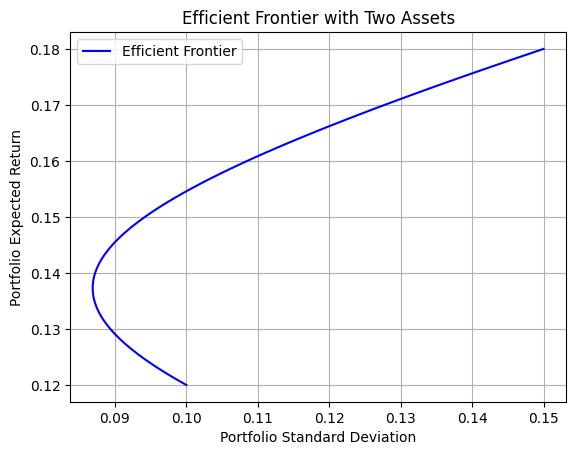

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Given Data
mean_returns = [0.12, 0.18]  
cov_matrix = [[0.1**2, 0.03*0.05], [0.03*0.05, 0.15**2]]  

weights = np.linspace(0, 1, 100)
portfolio_returns = []
portfolio_volatilities = []


for weight in weights:
    port_return = np.dot([weight, 1-weight], mean_returns)
    port_variance = np.dot([weight, 1-weight], np.dot(cov_matrix, [weight, 1-weight]))
    port_stddev = np.sqrt(port_variance)
    
    portfolio_returns.append(port_return)
    portfolio_volatilities.append(port_stddev)


plt.plot(portfolio_volatilities, portfolio_returns, 'b-', label='Efficient Frontier')
plt.title('Efficient Frontier with Two Assets')
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Expected Return')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
